In [127]:
import Algorithmia
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from userConfig import socrataClient, algoKey #importing our SODAPy and Algorithmia user configurations
import dateutil.parser
import seaborn as sns
%matplotlib notebook #show the plots right in the iPython notebook
sns.set(color_codes=True)


UsageError: unrecognized arguments: #show the plots right in the iPython notebook

In [128]:
#make a single request to CFPB / Socrata dataset
try:
    response = socrataClient.get("nsyy-je5y", content_type="json",limit=1)
    print("Response received")
    print(response)
except:
    print('Got an error code')

data = response[0]

Response received
[{'zip_code': '188XX', 'issue': 'Incorrect information on credit report', 'company': 'TransUnion Intermediate Holdings, Inc.', 'submitted_via': 'Web', 'date_received': '2016-04-27T13:14:00', 'complaint_what_happened': 'Latest update on XXXX XXXX. Filed for judgment and won. I do not owe XXXX any money and in fact they owe me money. They owe me {$460.00} as per case no. XXXX. attached. \n', 'sub_issue': 'Account terms', 'state': 'PA', 'company_response': 'Closed with non-monetary relief', 'tags': 'Servicemember', 'consumer_consent_provided': 'Consent provided', 'complaint_id': '1898518', 'consumer_disputed': 'No', 'date_sent_to_company': '2016-04-27T13:14:00', 'timely': 'Yes', 'company_public_response': 'Company has responded to the consumer and the CFPB and chooses not to provide a public response', 'product': 'Credit reporting'}]


In [129]:
#extract just the narrative text for records 
complaintText = data["complaint_what_happened"]

#print(complaintText)

In [130]:
#posting text to Algorithmia - Social Sentiment Analysis API, for scoring of text
#https://algorithmia.com/algorithms/nlp/SocialSentimentAnalysis
try:
    algoClient = Algorithmia.client(algoKey).algo('nlp/SocialSentimentAnalysis/0.1.2')
    daInput = {"sentence":complaintText}
    AlgoResponse = algoClient.pipe(daInput)
    print(AlgoResponse)
except:
    print("An error occurred")

AlgoResponse(result=[{'neutral': 0.84, 'positive': 0.1, 'compound': 0.3612, 'sentence': 'Latest update on XXXX XXXX. Filed for judgment and won. I do not owe XXXX any money and in fact they owe me money. They owe me {$460.00} as per case no. XXXX. attached. \n', 'negative': 0.06}],metadata=Metadata(content_type='json',duration=0.11977717700000001,stdout=None))


In [131]:
#isolating our 'compound' Social Sentiment score for this particular complaint
compoundScore = AlgoResponse.result[0]['compound']
print(compoundScore)

0.3612


In [132]:
#get multiple complaint records from CFPB
try:
    response = socrataClient.get("nsyy-je5y", content_type="json",where="date_received>'2016-01-01'")
    print("Response received")
    #print("response is " + str(response))
except:
    print('Got an error code')

Response received


In [134]:
#building list of dates for eventual plotting alongside Algorithmia scores
#ISOdateList = []
#for num in range(0,numComps):
#    daDate = response[num]["date_received"]
#    ISOdateList.append(daDate)
#print("ISOdateList is " + str(ISOdateList))

In [135]:
#parsing these dates from Socrata's ISO 860 format into Python's datetime requirement
#dateList = []
#for isoDate in ISOdateList:
#    date = dateutil.parser.parse(isoDate) # parsing ISO 8601 extended format
#    dateList.append(date)
#print(dateList[:5])

#then converting datetime values to format required for matplotlib
#dates = mdates.date2num(dateList)
#print(dates)

[datetime.datetime(2016, 4, 23, 14, 6, 35), datetime.datetime(2016, 4, 21, 22, 3, 18), datetime.datetime(2016, 4, 20, 22, 12, 17), datetime.datetime(2016, 4, 20, 20, 19, 1), datetime.datetime(2016, 4, 20, 18, 58, 21)]


In [136]:
#building a list of sentences to send to Algorithmia Social Sentiment API
sentList = []
for num in range(0,len(response)):
    complaintText = response[num]["complaint_what_happened"]
    sentList.append(complaintText)

#print("Sentence List is " + str(sentList))
print("Sentence List built")

Sentence List built


In [137]:
#send list of complaints to Algorithmia for scoring
algoClient = Algorithmia.client(algoKey).algo('nlp/SocialSentimentAnalysis/0.1.2')
daInput = {"sentenceList":sentList}
AlgoResponse = algoClient.pipe(daInput)
#print(AlgoResponse)
print("AlgoResponse received")

AlgoResponse received


In [138]:
#collecting scores together into parallel list
scoreList = []
for x in range(0,len(response)):
    daScore = AlgoResponse.result[x]["compound"]
    scoreList.append(daScore)

print(scoreList[:5])

[0.3612, -0.5873, -0.5873, 0.0018, 0.965]


In [139]:
####now, we'll plot the scores over time to see if positivity/negativity has changed####
#plot_date(dates, scoreList)

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.plot(dates,scoreList,"o")
#plt.gcf().autofmt_xdate()

#plt.plot(dates,scoreList)

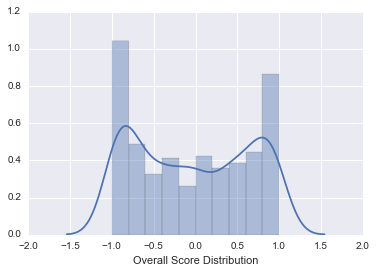

In [140]:
#plotting a histogram of all scores
sns.distplot(scoreList, bins=10, axlabel = "Overall Score Distribution")

Response received
Sentence List built
AlgoResponse received
[0, -0.0516, -0.9337, 0.1027, 0.964]
Response received
Sentence List built
AlgoResponse received
[0.171, -0.8779, 0.8225, 0.0387, 0.765]


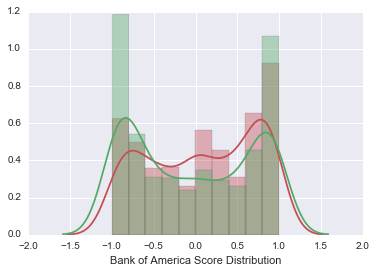

In [144]:
###Running the same thing for different financial service providers
companyList = ["Equifax","Bank of America"]

for company in companyList:
    try:
        response = socrataClient.get("nsyy-je5y", content_type="json",where="date_received>'2016-01-01'", company=company)
        print("Response received")
        #print("response is " + str(response))
    except:
        print('Got an error code')

    #building a list of sentences to send to Algorithmia Social Sentiment API
    sentList = []
    for num in range(0,len(response)):
        complaintText = response[num]["complaint_what_happened"]
        sentList.append(complaintText)

    #print("Sentence List is " + str(sentList))
    print("Sentence List built")
    #data = response[2]
    #print(data)

    #send list of complaints to Algorithmia for scoring
    algoClient = Algorithmia.client(algoKey).algo('nlp/SocialSentimentAnalysis/0.1.2')
    daInput = {"sentenceList":sentList}
    AlgoResponse = algoClient.pipe(daInput)
    #print(AlgoResponse)
    print("AlgoResponse received")

    #collecting scores together into parallel list
    scoreList = []
    for x in range(0,len(response)):
        daScore = AlgoResponse.result[x]["compound"]
        scoreList.append(daScore)

    print(scoreList[:5])

    #plotting a histogram of scores
    if company == "Equifax":
        sns.distplot(scoreList, bins=10, color="r", axlabel = company + " Score Distribution")
    elif company == "Bank of America":
        sns.distplot(scoreList, bins=10, color="g", axlabel = company + " Score Distribution")
    else:
        print("An error occurred")